<a href="https://colab.research.google.com/github/Marcosuff/Marcosuff.github.io/blob/master/nbs/download_chembl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai2

In [81]:

%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from os.path import join
from fastai2.tabular.all import *

In [ ]:
# RUN THIS CELL ONCE TO DOWNLOAD ChEMBL
#!wget -c http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_27/chembl_27_sqlite.tar.gz
#!tar -xvf /content/chembl_27_sqlite.tar.gz

In [ ]:
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! bash Anaconda3-2019.10-Linux-x86_64.sh -bfp /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages')
!conda install -y -c rdkit rdkit

In [ ]:
ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Blog'      # path to your project on Drive

GIT_USERNAME = "Marcosuff" # replace with yours
GIT_REPOSITORY = "Marcosuff.github.io"      # ...nah
GIT_TOKEN = 'dee4192a28a49b4acc3897425086d65cabe8b47f'

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"     # in case we haven't created it already   


In [8]:
GIT_PATH = "https://dee4192a28a49b4acc3897425086d65cabe8b47f@github.com/Marcosuff/Marcosuff.github.io.git"
!git clone "{GIT_PATH}"

fatal: destination path 'Marcosuff.github.io' already exists and is not an empty directory.


In [9]:
df = pd.read_csv('/content/Marcosuff.github.io/data/chembl27.csv.gz')

In [12]:
df.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
0,6570,4000.0,IC50,=,5.40,252199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4ccc(Cl)c(C(...,CHEMBL357278,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
1,6570,17000.0,IC50,=,4.77,253534,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...,CHEMBL357119,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
2,6570,180.0,IC50,=,6.75,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,CHEMBL152968,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
3,6570,6000.0,IC50,=,5.22,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,CHEMBL152968,12594,CHEMBL3356,Enzyme,Cytochrome P450,Cytochrome P450 family 1,8
4,6570,37000.0,IC50,=,4.43,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,CHEMBL152968,17045,CHEMBL340,Enzyme,Cytochrome P450,Cytochrome P450 family 3,8


Everything seems fine with the raw data. The dataframe loaded just fine and the columns are as expected. 

Now we are going to select a subset of it. In this case, just one protein target: coagulation factor Xa


In [13]:
fxa = df[df['target_chembl_id']=='CHEMBL244']
print(fxa.shape)
fxa.head()

(6515, 14)


,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
22,3476,44.4,IC50,=,7.35,192068,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c...,CHEMBL117716,194,CHEMBL244,Enzyme,Protease,Serine protease,8
273,6512,180.0,IC50,=,6.75,203908,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)cc...,CHEMBL337921,194,CHEMBL244,Enzyme,Protease,Serine protease,8
274,6512,120.0,IC50,=,6.92,204329,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)cc...,CHEMBL340500,194,CHEMBL244,Enzyme,Protease,Serine protease,8
288,3476,311.0,IC50,=,6.51,192044,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CNC(=O)c2...,CHEMBL117721,194,CHEMBL244,Enzyme,Protease,Serine protease,8
291,3476,6.1,IC50,=,8.21,191486,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c...,CHEMBL331807,194,CHEMBL244,Enzyme,Protease,Serine protease,8


If we want to train a reliable model, we need active and inactive compounds. This is the same as in binary classification problems; now the positive class is called "active" and the negative class is "inactive". 
Before we start training our classifier, let's take a look at the data.

**Questions**



1.   What is the number of active molecules? And inactive?
2.   Is the data unbalanced?

## **EDA**

In [24]:
ic50s = fxa[fxa['standard_type']=='IC50']

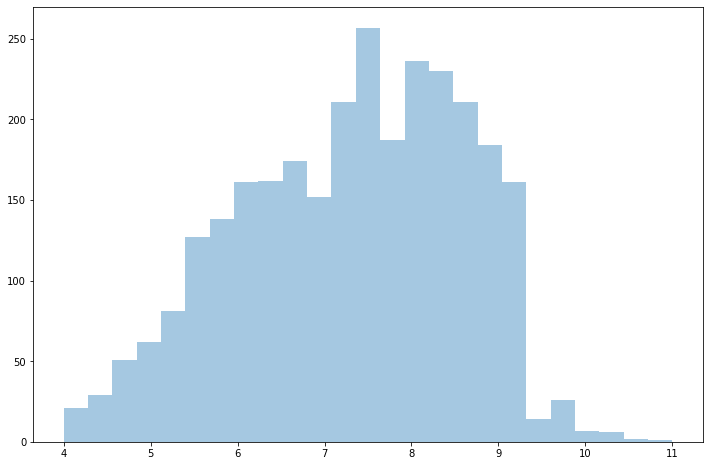

In [25]:
# Distribution of IC50 values
fig = plt.figure(figsize=(12,8))

sns.distplot(a=ic50s['pchembl'].values,kde=False)

Maybe we can select an activity cutoff of 6.5 (~10uM)

In [32]:
fxa_ic50 = fxa[(~fxa['pchembl'].isnull()) & (~fxa['canonical_smiles'].isnull()) & (fxa['standard_type']=='IC50') & (fxa['standard_relation'] == '=')]
np.unique(fxa_ic50['standard_type'].values),np.unique(fxa_ic50['standard_relation'].values)

(array(['IC50'], dtype=object), array(['='], dtype=object))

In [34]:
fxa_ic50['act'] =  np.where(fxa_ic50['pchembl']>=6.5,'Active','Inactive')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
fxa_ic50.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score,act
22,3476,44.4,IC50,=,7.35,192068,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c...,CHEMBL117716,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active
273,6512,180.0,IC50,=,6.75,203908,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)cc...,CHEMBL337921,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active
274,6512,120.0,IC50,=,6.92,204329,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)cc...,CHEMBL340500,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active
288,3476,311.0,IC50,=,6.51,192044,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CNC(=O)c2...,CHEMBL117721,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active
291,3476,6.1,IC50,=,8.21,191486,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c...,CHEMBL331807,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active


## Compute Fingerprints (Features)

We are going to use Morgan Circular fingerprints implemented in RDKit:

`AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024)`

In [49]:
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, DataStructs

In [70]:
def getfp(mol):
  '''Returns Morgan fingerprints for a molecule'''
  arr = np.zeros((0,), dtype=np.int8)
  fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(mol),radius=2,nBits=1024)
  DataStructs.ConvertToNumpyArray(fp,arr)
  return arr.reshape(1,1024)
*fps, = map(getfp,list(fxa_ic50['canonical_smiles'].values))

In [83]:
cat_names = ['fp{}'.format(x) for x in range(1024)]
fps_df = pd.DataFrame(np.concatenate(fps, axis=0),columns=cat_names)

In [73]:
fps_df.head()

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,...,fp984,fp985,fp986,fp987,fp988,fp989,fp990,fp991,fp992,fp993,fp994,fp995,fp996,fp997,fp998,fp999,fp1000,fp1001,fp1002,fp1003,fp1004,fp1005,fp1006,fp1007,fp1008,fp1009,fp1010,fp1011,fp1012,fp1013,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [93]:
fps_df.shape,fxa_ic50.shape

((2891, 1024), (2891, 15))

In [92]:
fxa_ic50.reset_index(drop=True,inplace=True)
merged_data = pd.concat([fxa_ic50,fps_df],axis = 1)

In [94]:
merged_data.isnull().any()

doc_id               False
standard_value       False
standard_type        False
standard_relation    False
pchembl              False
                     ...  
fp1019               False
fp1020               False
fp1021               False
fp1022               False
fp1023               False
Length: 1039, dtype: bool

## Create dataloaders

In [82]:
doc(TabularDataLoaders)

TabularDataLoaders(*loaders, path='.', device=None)
Basic wrapper around several `DataLoader`s with factory methods for tabular data

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [95]:
dls = TabularDataLoaders.from_df(df=merged_data,procs=[Categorify],
                                 cat_names=cat_names,cont_names=[],y_names='act')

In [96]:
dls.show_batch()

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,fp40,fp41,fp42,fp43,fp44,fp45,fp46,fp47,fp48,fp49,fp50,fp51,fp52,fp53,fp54,fp55,fp56,fp57,fp58,fp59,fp60,fp61,fp62,fp63,fp64,fp65,fp66,fp67,fp68,fp69,fp70,fp71,fp72,fp73,fp74,fp75,fp76,fp77,fp78,fp79,fp80,fp81,fp82,fp83,fp84,fp85,fp86,fp87,fp88,fp89,fp90,fp91,fp92,fp93,fp94,fp95,fp96,fp97,fp98,fp99,fp100,fp101,fp102,fp103,fp104,fp105,fp106,fp107,fp108,fp109,fp110,fp111,fp112,fp113,fp114,fp115,fp116,fp117,fp118,fp119,fp120,fp121,fp122,fp123,fp124,fp125,fp126,fp127,fp128,fp129,fp130,fp131,fp132,fp133,fp134,fp135,fp136,fp137,fp138,fp139,fp140,fp141,fp142,fp143,fp144,fp145,fp146,fp147,fp148,fp149,fp150,fp151,fp152,fp153,fp154,fp155,fp156,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166,fp167,fp168,fp169,fp170,fp171,fp172,fp173,fp174,fp175,fp176,fp177,fp178,fp179,fp180,fp181,fp182,fp183,fp184,fp185,fp186,fp187,fp188,fp189,fp190,fp191,fp192,fp193,fp194,fp195,fp196,fp197,fp198,fp199,fp200,fp201,fp202,fp203,fp204,fp205,fp206,fp207,fp208,fp209,fp210,fp211,fp212,fp213,fp214,fp215,fp216,fp217,fp218,fp219,fp220,fp221,fp222,fp223,fp224,fp225,fp226,fp227,fp228,fp229,fp230,fp231,fp232,fp233,fp234,fp235,fp236,fp237,fp238,fp239,fp240,fp241,fp242,fp243,fp244,fp245,fp246,fp247,fp248,fp249,fp250,fp251,fp252,fp253,fp254,fp255,fp256,fp257,fp258,fp259,fp260,fp261,fp262,fp263,fp264,fp265,fp266,fp267,fp268,fp269,fp270,fp271,fp272,fp273,fp274,fp275,fp276,fp277,fp278,fp279,fp280,fp281,fp282,fp283,fp284,fp285,fp286,fp287,fp288,fp289,fp290,fp291,fp292,fp293,fp294,fp295,fp296,fp297,fp298,fp299,fp300,fp301,fp302,fp303,fp304,fp305,fp306,fp307,fp308,fp309,fp310,fp311,fp312,fp313,fp314,fp315,fp316,fp317,fp318,fp319,fp320,fp321,fp322,fp323,fp324,fp325,fp326,fp327,fp328,fp329,fp330,fp331,fp332,fp333,fp334,fp335,fp336,fp337,fp338,fp339,fp340,fp341,fp342,fp343,fp344,fp345,fp346,fp347,fp348,fp349,fp350,fp351,fp352,fp353,fp354,fp355,fp356,fp357,fp358,fp359,fp360,fp361,fp362,fp363,fp364,fp365,fp366,fp367,fp368,fp369,fp370,fp371,fp372,fp373,fp374,fp375,fp376,fp377,fp378,fp379,fp380,fp381,fp382,fp383,fp384,fp385,fp386,fp387,fp388,fp389,fp390,fp391,fp392,fp393,fp394,fp395,fp396,fp397,fp398,fp399,fp400,fp401,fp402,fp403,fp404,fp405,fp406,fp407,fp408,fp409,fp410,fp411,fp412,fp413,fp414,fp415,fp416,fp417,fp418,fp419,fp420,fp421,fp422,fp423,fp424,fp425,fp426,fp427,fp428,fp429,fp430,fp431,fp432,fp433,fp434,fp435,fp436,fp437,fp438,fp439,fp440,fp441,fp442,fp443,fp444,fp445,fp446,fp447,fp448,fp449,fp450,fp451,fp452,fp453,fp454,fp455,fp456,fp457,fp458,fp459,fp460,fp461,fp462,fp463,fp464,fp465,fp466,fp467,fp468,fp469,fp470,fp471,fp472,fp473,fp474,fp475,fp476,fp477,fp478,fp479,fp480,fp481,fp482,fp483,fp484,fp485,fp486,fp487,fp488,fp489,fp490,fp491,fp492,fp493,fp494,fp495,fp496,fp497,fp498,fp499,fp500,fp501,fp502,fp503,fp504,fp505,fp506,fp507,fp508,fp509,fp510,fp511,fp512,fp513,fp514,fp515,fp516,fp517,fp518,fp519,fp520,fp521,fp522,fp523,fp524,fp525,fp526,fp527,fp528,fp529,fp530,fp531,fp532,fp533,fp534,fp535,fp536,fp537,fp538,fp539,fp540,fp541,fp542,fp543,fp544,fp545,fp546,fp547,fp548,fp549,fp550,fp551,fp552,fp553,fp554,fp555,fp556,fp557,fp558,fp559,fp560,fp561,fp562,fp563,fp564,fp565,fp566,fp567,fp568,fp569,fp570,fp571,fp572,fp573,fp574,fp575,fp576,fp577,fp578,fp579,fp580,fp581,fp582,fp583,fp584,fp585,fp586,fp587,fp588,fp589,fp590,fp591,fp592,fp593,fp594,fp595,fp596,fp597,fp598,fp599,fp600,fp601,fp602,fp603,fp604,fp605,fp606,fp607,fp608,fp609,fp610,fp611,fp612,fp613,fp614,fp615,fp616,fp617,fp618,fp619,fp620,fp621,fp622,fp623,fp624,fp625,fp626,fp627,fp628,fp629,fp630,fp631,fp632,fp633,fp634,fp635,fp636,fp637,fp638,fp639,fp640,fp641,fp642,fp643,fp644,fp645,fp646,fp647,fp648,fp649,fp650,fp651,fp652,fp653,fp654,fp655,fp656,fp657,fp658,fp659,fp660,fp661,fp662,fp663,fp664,fp665,fp666,fp667,fp668,fp669,fp670,fp671,fp672,fp673,fp674,fp675,fp676,fp677,fp678,fp679,fp680,fp681,fp682,fp683,fp684

In [104]:
learn = tabular_learner(dls,metrics=MatthewsCorrCoef())

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.001737800776027143)

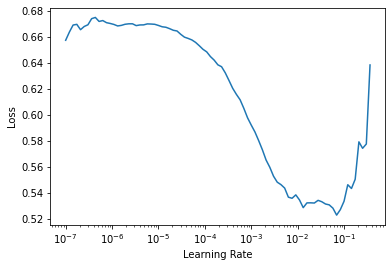

In [98]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=10,base_lr=1e-3)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.515089,0.607647,0.000000,00:10


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.271789,0.477079,0.565614,00:10
1,0.232183,0.304745,0.636366,00:10
2,0.217180,0.342333,0.629225,00:10
3,0.183375,0.380605,0.602979,00:10
4,0.150815,0.402322,0.634296,00:10
